In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pingouin as pg
%matplotlib inline

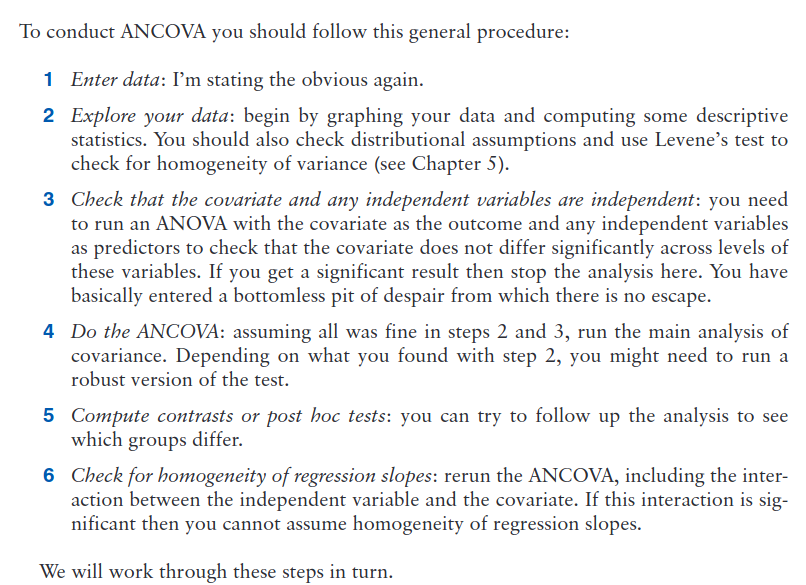

In [242]:
from IPython.display import Image
Image('1.png')

In [243]:
data = pd.read_csv('ViagraCovariate.csv')

In [244]:
data.head()

,dose,libido,partnerLibido
0,1,3,4
1,1,2,1
2,1,5,5
3,1,2,1
4,1,2,2


In [245]:
data.groupby('dose').describe()

libido                                              partnerLibido  \
      count      mean       std  min  25%  50%  75%  max         count   
dose                                                                     
1       9.0  3.222222  1.787301  2.0  2.0  2.0  4.0  7.0           9.0   
2       8.0  4.875000  1.457738  3.0  4.0  4.5  5.5  7.0           8.0   
3      13.0  4.846154  2.115268  2.0  4.0  4.0  6.0  9.0          13.0   

                                                    
          mean       std  min  25%  50%   75%  max  
dose                                                
1     3.444444  2.068279  1.0  2.0  4.0  5.00  7.0  
2     3.125000  1.726888  1.0  2.0  2.5  4.25  6.0  
3     2.000000  1.632993  0.0  1.0  2.0  3.00  5.0

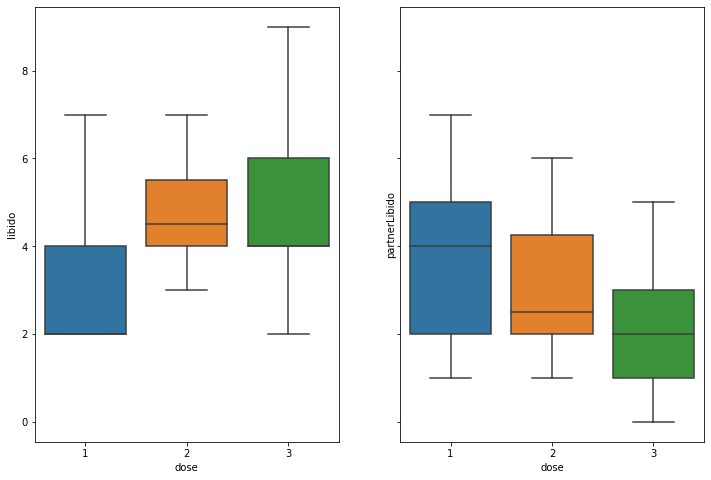

In [246]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(12,8))
_ = sns.boxplot(x='dose', y='libido', data=data, ax=ax1)
_ = sns.boxplot(x='dose', y='partnerLibido', data=data, ax=ax2)

In [247]:
data_1 = data[data['dose']==1]
data_2 = data[data['dose']==2]
data_3 = data[data['dose']==3]

In [248]:
st.levene(data_1['libido'], data_2['libido'], data_3['libido'])

LeveneResult(statistic=0.3255636973602896, pvalue=0.7249155808037104)

#### it shows that homogeneity of variance is followed, let's do a good double check using Hartley's Fmax test

In [249]:
F_max = 2.115268**2/1.457738**2
F_max

2.1055804943265355

#### from hartley's fmax table our fmax is less than the critical value of 5.34 (dof=9, k=3),  so our variance is homogeneous.

In [250]:
m01 = smf.ols('partnerLibido~C(dose)', data=data).fit()
anova_table = sm.stats.anova_lm(m01)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(dose),2.0,12.769444,6.384722,1.979254,0.157718
Residual,27.0,87.097222,3.225823,NaN,NaN


### It shows the results of such an ANOVA. The main effect of dose is not significant, F(2, 27) = 1.98, p = .16, which shows that the average level of partner’s libido was roughly the same in the three Viagra groups. In other words, the means for partner’s libido are not significantly different in the placebo, low and high-dose groups. This result means that it is appropriate to use partner’s libido as a covariate in the analysis

In [251]:
m02 = smf.ols('libido~partnerLibido+C(dose)', data=data).fit()
m02.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 libido   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     3.500
Date:                Wed, 05 Aug 2020   Prob (F-statistic):             0.0295
Time:                        11:10:24   Log-Likelihood:                -57.101
No. Observations:                  30   AIC:                             122.2
Df Residuals:                      26   BIC:                             127.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.7892      0.867      2.063      0.049       0.007       3.572
C(dose)[T.2]      1.7857      0.849      2.102      0.045       0.040       3.532
C(dose)[T.3]      2.2249      0.803      2.771      0.010       0.575       3.875
partnerLibido     0.4160      0.187      2.227      0.035       0.032       0.800
==============================================================================
Omnibus:                        5.853   Durbin-Watson:                   2.559
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                4.111
Skew:                           0.743   Prob(JB):                        0.128
Kurtosis:                       4.040   Cond. No.                         13.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [252]:
anova_table2 = sm.stats.anova_lm(m02, typ=2)
anova_table2

,sum_sq,df,F,PR(>F)
C(dose),25.185194,2.0,4.141929,0.027447
partnerLibido,15.075748,1.0,4.958681,0.034833
Residual,79.047116,26.0,NaN,NaN


In [253]:
from patsy.contrasts import ContrastMatrix

### ***NOTE: To calculate Type III sums of squares properly we must specify orthogonal contrasts***

In [254]:
m03 = smf.ols('libido~partnerLibido+C(dose, Helmert)', data=data).fit()
anova_table2 = sm.stats.anova_lm(m03, typ=3)
anova_table2

,sum_sq,df,F,PR(>F)
Intercept,76.069037,1.0,25.020457,0.000033
"C(dose, Helmert)",25.185194,2.0,4.141929,0.027447
partnerLibido,15.075748,1.0,4.958681,0.034833
Residual,79.047116,26.0,NaN,NaN


## Adjusted Means
### http://www.real-statistics.com/analysis-of-covariance-ancova/regression-approach-ancova/

In [255]:
m02.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 libido   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     3.500
Date:                Wed, 05 Aug 2020   Prob (F-statistic):             0.0295
Time:                        11:10:25   Log-Likelihood:                -57.101
No. Observations:                  30   AIC:                             122.2
Df Residuals:                      26   BIC:                             127.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.7892      0.867      2.063      0.049       0.007       3.572
C(dose)[T.2]      1.7857      0.849      2.102      0.045       0.040       3.532
C(dose)[T.3]      2.2249      0.803      2.771      0.010       0.575       3.875
partnerLibido     0.4160      0.187      2.227      0.035       0.032       0.800
==============================================================================
Omnibus:                        5.853   Durbin-Watson:                   2.559
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                4.111
Skew:                           0.743   Prob(JB):                        0.128
Kurtosis:                       4.040   Cond. No.                         13.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### **We now turn our attention to the treatment means ,  adjusted to remove the effect of the covariate.**

### ***y = 1.7892 + 0.4160 * partnerLibido + 1.7857 * t2 + 2.2249 * t3***

In [256]:
y_placebo = 1.7892 + 0.4160* data['partnerLibido'].mean() + 0 + 0
y_placebo

2.926266666666667

In [257]:
y_low = 1.7892 + 0.4160* data['partnerLibido'].mean() + 1* 1.7857 + 0
y_low

4.711966666666667

In [258]:
y_high = 1.7892 + 0.4160* data['partnerLibido'].mean() + 0* 1.7857 + 1* 2.2249
y_high

5.151166666666667

###    Planned contrasts in ANCOVA

In [259]:
contrast1 = [-2, 1, 1]
contrast2 = [0,-1, 1]
contrast = np.vstack((contrast1, contrast2))
contrast = contrast.T
contrast

array([[-2,  0],
       [ 1, -1],
       [ 1,  1]])

In [260]:
planned_custom = smf.ols("libido ~ partnerLibido+C(dose, contrast)", data=data)
res_custom = planned_custom.fit()
print(res_custom.summary())

                            OLS Regression Results                            
Dep. Variable:                 libido   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     3.500
Date:                Wed, 05 Aug 2020   Prob (F-statistic):             0.0295
Time:                        11:10:26   Log-Likelihood:                -57.101
No. Observations:                  30   AIC:                             122.2
Df Residuals:                      26   BIC:                             127.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

####  **The  first  dummy  variable  (dose1)  compares  the  placebo group with the low- and high-dose groups.** 

#### **The second dummy variable (dose2) compares the low- and high-dose groups, and so the b-value should be the difference between the adjusted means of these groups: (5.15−4.71)/2 =0.22.**

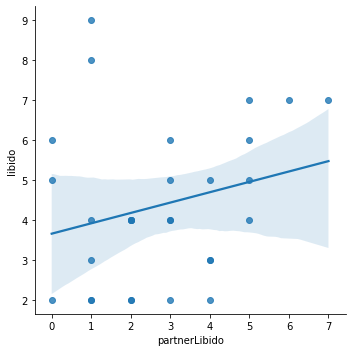

In [261]:
#   Interpreting the covariate
_ = sns.lmplot(y='libido', x="partnerLibido", data=data)

#### **Figure shows the resulting scatterplot for these data and confirms what we already know: the effect of the covariate is that as partner’s libido increases, so does the participant’s libido (as shown by the slope of the regression line).**

### **Post Hoc tests in ANCOVA**

## ***I was not able to find appropriate python package to do Post-Hoc test on adjusted means in python, So just pasting R's output***

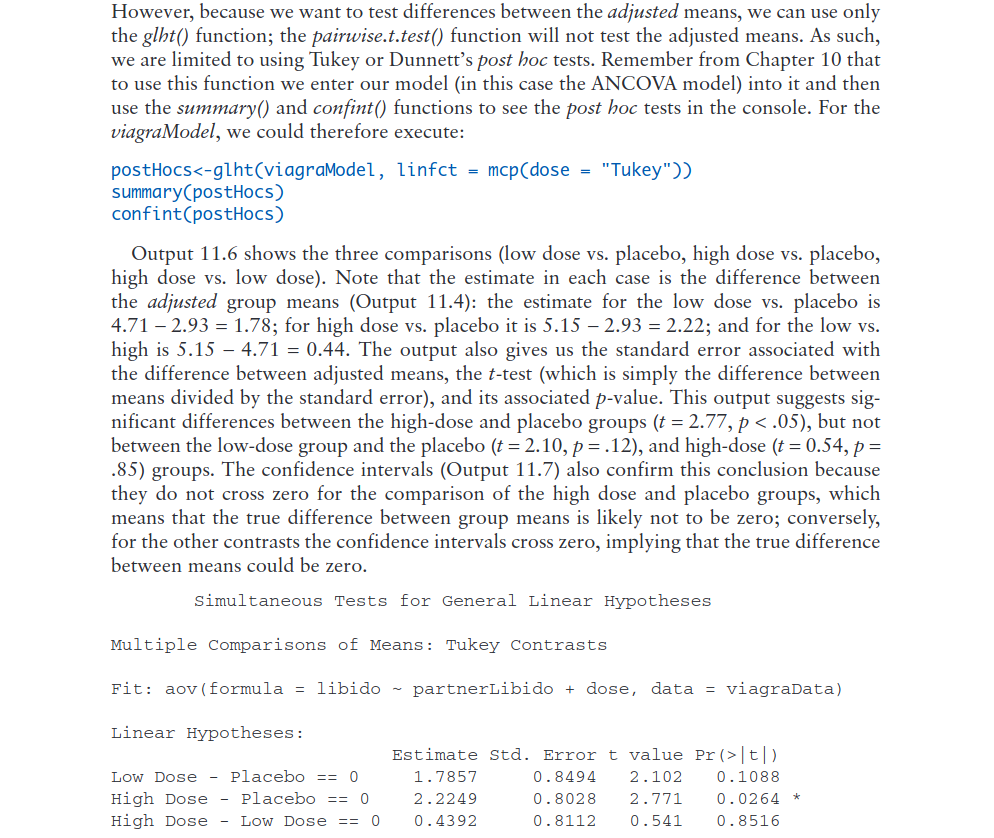

In [262]:
Image('ancovaPostHoc.png')

## **Plots in ANCOVA**

In [263]:
prediction = pd.DataFrame(m02.fittedvalues)
prediction.columns = ['predicted'] 
prediction.head()

,predicted
0,3.453357
1,2.205230
2,3.869399
3,2.205230
4,2.621273


In [264]:
prediction['standarized_prediction']  = (prediction['predicted']-prediction['predicted'].mean())/prediction['predicted'].std()

In [265]:
import statsmodels.stats.outliers_influence as sms

In [266]:
summary_frame = sms.OLSInfluence(m02).summary_frame()

In [267]:
summary_frame = pd.merge(summary_frame, prediction, how = 'inner', left_index = True, right_index = True)

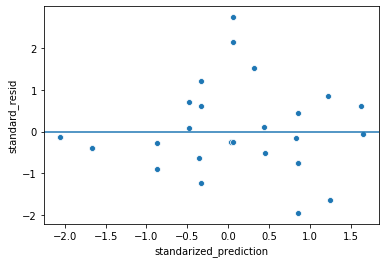

In [268]:
_ = sns.scatterplot(y = 'standard_resid', x='standarized_prediction', data = summary_frame)
_ = plt.axhline(y=0)

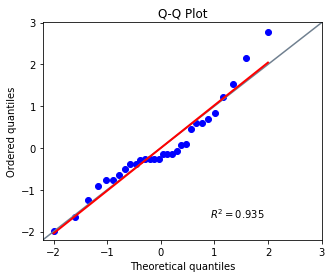

In [269]:
_ = pg.qqplot(summary_frame['standard_resid'], confidence=False)

### ***The first graph (on the left of the figure) can be used for testing homoge-neity of variance. We encountered this kind of plot in Chapter 7: if it has a funnel shape then we’re in trouble. The plot we have does show funnelling (the spread of scores is wider at some points than at others), which implies that the residuals might be heteroscedastic (a bad thing). The second plot (on the right) is a Q-Q plot , which tells us about the normality of residuals in the model. We want our residuals to be normally dis-tributed, which means that the dots on the graph should hover around the diagonal line. On ours, it looks like the diagonal line has not washed for several weeks and the dots are running away from the smell. Again, this is not good news for the model. These plots sug-gest that a robust version of ANCOVA might be in order***

## **Final Remarks**

In [270]:
m05 = smf.ols('libido~C(dose)', data=data).fit()
m05.summary()
anovaTable = sm.stats.anova_lm(m05)
anovaTable

,df,sum_sq,mean_sq,F,PR(>F)
C(dose),2.0,16.843803,8.421902,2.415899,0.108339
Residual,27.0,94.122863,3.486032,NaN,NaN


### This example illustrates how ANCOVA can help us to exert stricter experimental control by  taking  account  of  confounding  variables  to  give  us  a  ‘purer’  measure  of  effect  of  the experimental manipulation. above output shows  the ANOVA table for these data when the covariate is not included. It is clear from the significance value, which is greater than .05, that Viagra seems to have no significant effect on libido. Therefore, without taking account of  the  libido  of  the  participants’  partners  we  would  have  concluded  that  Viagra  had  no significant effect on libido, yet it does.

## **Testing for homogeneity of regression slope**

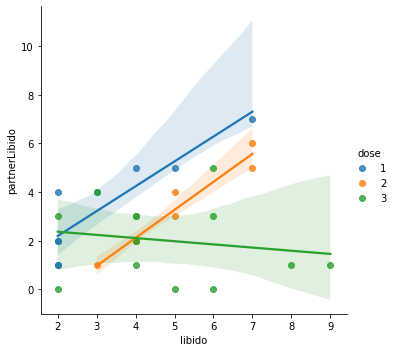

In [271]:
_ = sns.lmplot(x='libido', y='partnerLibido', hue='dose', data=data)       # groupwise effect

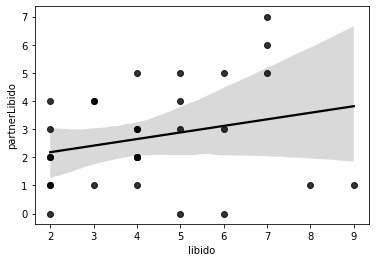

In [272]:
_ = sns.regplot(x='libido', y='partnerLibido', data=data, color='black')   # overall effect

#### ***Note: see https://stackoverflow.com/questions/33050104/difference-between-the-interaction-and-term-for-formulas-in-statsmodels-ols***

In [273]:
hoRS= smf.ols('libido~C(dose, contrast)*partnerLibido', data=data).fit()
anova_hoRS = sm.stats.anova_lm(hoRS, typ=3)
anova_hoRS

,sum_sq,df,F,PR(>F)
Intercept,53.541872,1.0,21.920735,0.000093
"C(dose, contrast)",36.557560,2.0,7.483569,0.002980
partnerLibido,17.182224,1.0,7.034625,0.013947
"C(dose, contrast):partnerLibido",20.426594,2.0,4.181456,0.027667
Residual,58.620522,24.0,NaN,NaN


### **shows the main summary table for the ANCOVA including the interaction term. The effects of the dose of Viagra and the partner’s libido are still significant, but the main  thing  in  which  we’re  interested  is  the  interaction  term,  so  look  at  the  significance value  of  the  covariate  by  outcome  interaction  (partnerLibido:dose),  if  this  effect  is  sig-nificant  then  the  assumption  of  homogeneity  of  regression  slopes  has  been  broken.  The effect here is significant (p < .05); therefore the assumption is not tenable. Although this finding is not surprising given the pattern of relationships in above plots, it does raise concern about the main analysis. This example illustrates why it is important to test assumptions and not to just blindly accept the results of an analysis**

### ***Note:  We could also use Type II sums of squares here: because we’re interested only in the highest-order interaction, Type II and III sums of squares will give us exactly the same results***

### **Robust Ancova**

In [274]:
rob= smf.ols('libido~partnerLibido+C(dose)', data=data).fit()
anova_rob = sm.stats.anova_lm(rob, typ=2,robust='hc3')
anova_rob

,sum_sq,df,F,PR(>F)
C(dose),48.144375,2.0,7.917770,0.002063
partnerLibido,13.345686,1.0,4.389633,0.046046
Residual,79.047116,26.0,NaN,NaN


In [275]:
df = pd.read_csv('cloak.csv')

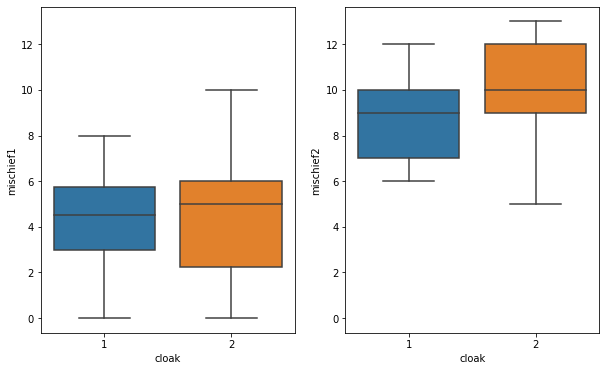

In [276]:
plt.figure(figsize=(10,6))
ax1 = plt.subplot(121)
_ = sns.boxplot(x='cloak', y='mischief1', data=df)
ax2 = plt.subplot(122, sharey=ax1)
_ = sns.boxplot(x='cloak', y='mischief2', data=df)

In [277]:
df.head()

,cloak,mischief1,mischief2
0,1,4,11
1,1,5,7
2,1,8,8
3,1,6,7
4,1,6,10


In [278]:
rob_cloak= smf.ols('mischief2~mischief1+C(cloak)', data=df).fit()
anova_cloak = sm.stats.anova_lm(rob_cloak, typ=2,robust='hc3')
anova_cloak

,sum_sq,df,F,PR(>F)
C(cloak),35.005576,1.0,11.274144,0.001224
mischief1,25.618980,1.0,8.251030,0.005260
Residual,239.080622,77.0,NaN,NaN


## **Summary**

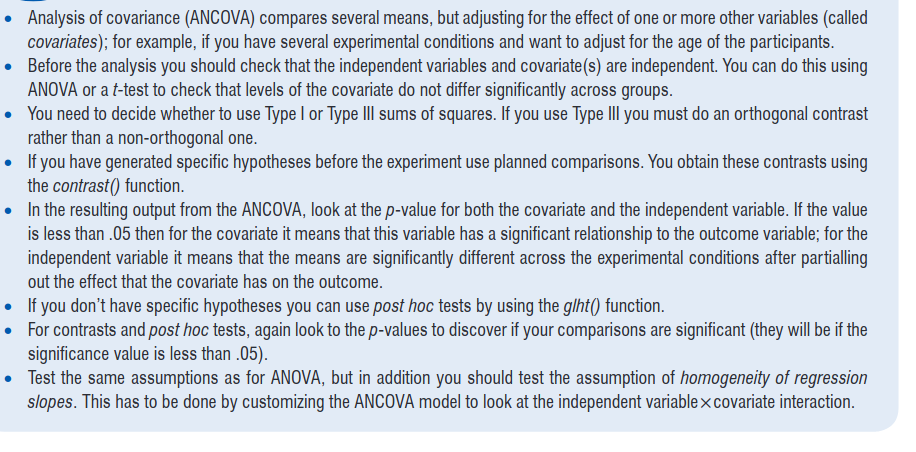

In [279]:
Image('ancov.png')

## **Calculating the effect size**

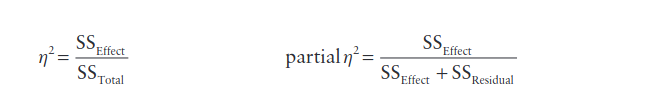

In [280]:
Image('effect.png')

In [281]:
anova_table2

,sum_sq,df,F,PR(>F)
Intercept,76.069037,1.0,25.020457,0.000033
"C(dose, Helmert)",25.185194,2.0,4.141929,0.027447
partnerLibido,15.075748,1.0,4.958681,0.034833
Residual,79.047116,26.0,NaN,NaN


In [282]:
partial_η2_dose = 25.185194/(25.185194+79.047116)
partial_η2_partnerLibido = 15.075748/(15.075748+79.047116)

In [283]:
partial_η2_dose

0.24162559574857354

In [284]:
partial_η2_partnerLibido

0.16017094422456163

In [285]:
def r_contrast(t,df):
    return np.sqrt(t**2/(t**2+df))

In [286]:
df=26 # N-p-1 = 30-(2+1)-1

In [287]:
r_contrast(2.227,df)

0.40024235436415706

In [288]:
r_contrast(2.785,df)

0.4793450677347502

In [289]:
r_contrast(0.541,df)

0.10550664883954561

### If you think back to our benchmarks for effect sizes, the effect of the covariate (.400) and the difference between the combined dose groups and the placebo (.479) both represent medium to large effect sizes (they’re both between .4 and .5). Therefore, as well as being statistically significant, these effects are substantive findings. The difference between the high- and low-dose groups (.106) was a fairly small effect.

## **calculate effect sizes between all combinations of groups**

## https://www.rdocumentation.org/packages/compute.es/versions/0.2-5/topics/mes

In [290]:
def s_within(s1,s2,n1,n2):
    return np.sqrt((((n1-1)*(s1**2))+((n2-1)*(s2**2)))/(n1+n2-2))

def mes(m1, m2, s1, s2, n1, n2):
    s_ = s_within(s1,s2,n1,n2)
    d = (m1-m2)/s_   # cohen's D
    d_var = (n1+n2)/(n1*n2) + (d**2)/(2*(n1+n2))    # variance of d 
    
    df = n1+n2-2
    J = 1-3/(4*df-1)   # correction factor
    
    g = J*d          #   Hedges' g
    
    g_var = (J**2)*d_var     #   variance of g
    
    a = (n1+n2)**2/(n1*n2)    # a corrects for inbalance in n1 & n2
    
    r = d/np.sqrt(d**2+a)  # correlation coeffecient
    
    r_var = (a**2 * d_var)/((d**2 + a)**3)     #   variance of r
    
    
    print(f'Cohen\'s d: {d}, var.d: {d_var}')
    print(f'Hedge\'s g: {g}, var.g: {g_var}')
    print(f'Correlation coeffecient: {r}, var.r: {r_var}')
    

### We  know  the  adjusted  means   and  sample  sizes,  the  problem  is  that  we don’t know the adjusted standard deviations. We could either use the unadjusted standard deviations  as  an  approximation,  or  we  could  estimate  them  from  the  standard  errors  of the adjusted means

### using unadjusted standard deviations

In [291]:
# placebo-low
mes(2.92, 4.71, 1.79, 1.46, 9,8)

Cohen's d: -1.0886337947101665, var.d: 0.2709676857871422
Hedge's g: -1.033279533962192, var.g: 0.24411222712682507
Correlation coeffecient: -0.4774428394493218, var.r: 0.031066020760067054


In [292]:
# high-low
mes(5.15, 4.71, 2.11, 1.46, 13,8)

Cohen's d: 0.23199127672690636, var.d: 0.20320450436301454
Hedge's g: 0.2227116256578301, var.g: 0.1872732712209542
Correlation coeffecient: 0.1119515962214018, var.r: 0.04614191790941418


In [293]:
# high-placebo
mes(5.15, 2.92, 2.11, 1.79, 13,9)

Cohen's d: 1.1216231105793681, var.d: 0.2166259699020457
Hedge's g: 1.079029827899139, var.g: 0.20048575583307418
Correlation coeffecient: 0.4829027244028852, var.r: 0.02361053121522755


### The difference between the low-dose and placebo group is a large effect (the adjusted means are about a standard deviation different), d= -1.08, r=-.47; the difference between the high-dose and placebo groups is also a large effect (over a standard deviation difference between the adjusted group means), d= 1.12, r= .48; finally,he difference between the high- and low-dose groups is a very small effect (the adjusted means are about a tenth of standard deviation different), d= 0.23, r= .11

# **Reporting Results**

### ***The  covariate,  partner’s  libido,  was  significantly  related  to  the  participant’s  libido, F(1, 26) = 4.96, p < .05, r= .40. There was also a significant effect of the dose of Viagra on levels of libido after controlling for the effect of partner’s libido, F(2, 26) = 4.14, p < .05, partial η2= .24.***

### ***Planned  contrasts  revealed  that  taking  a  high  or  low  dose  of  Viagra  significantly increased libido compared to taking a placebo, t(26) = 2.79, p < .01, r= .48; there was no significant difference between the high and low doses of Viagra, t(26) = 0.54, p = .59, r= .11.***

### ***Tukey post hoc tests revealed that the covariate adjusted mean of the high-dose group was significantly greater than that of the placebo (difference = 2.22, t= 2.77, p< .05, d= 1.13). However, there was no significant difference between the low-dose and pla-cebo groups (difference = 1.79, t= 2.10, p= .11, d= 1.04) and between the low-dose and high-dose groups (difference = 0.44, t= 0.54, p= .85, d= 0.11). Despite the lack of significance between the low-dose and placebo groups, the effect size was quite large.***

Note 